# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Sentimental Analysis

In [0]:
import time
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import seaborn as sns
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Reading The Data File**

In [0]:
path="Enter Folder Path Here"
data=pd.read_csv(path+"Amazon_Unlocked_Mobile.csv")
print("The Dataset have {rows} rows and {cols} columns".format(rows=data.shape[0],cols=data.shape[1]))
print("The Columns have {cols} columns".format(cols=data.columns.values))

The Dataset have 413840 rows and 6 columns
The Columns have ['Product Name' 'Brand Name' 'Price' 'Rating' 'Reviews' 'Review Votes'] columns


**We are interested in Reviews and Rating Columns . So we remove rest of the columns**

In [0]:
data_re=data[["Rating","Reviews"]]

In [0]:
print("Total Number of  Reviews",len(data["Reviews"]))
print("Total Number of Unique Reviews are" ,len(data["Reviews"].unique()))

Total Number of  Reviews 413840
Total Number of Unique Reviews are 162492


**Droping Duplicates and NULL values**

In [0]:
data_re=data_re.drop_duplicates()
data_re=data_re.dropna()
print("Now The Dataset have {rows} rows and {cols} columns".format(rows=data_re.shape[0],cols=data_re.shape[1]))

Now The Dataset have 163961 rows and 2 columns


In [0]:
data_re["Rating"].unique()

array([5, 4, 1, 2, 3])

The Ratings goes from 1 to 5. 


Marking the Rating as :
><br> 1 and 2 as Negative.
><br> 4 and 5 as Positive.

<br>Delete the rows where ratings=3


In [0]:
data_re.loc[data_re["Rating"]<3,"sentiment"]="Negative"
data_re.loc[data_re["Rating"]>3,"sentiment"]="Positive"
indexNames = data_re[data_re["Rating"]==3].index
data_re=data_re.drop(indexNames )

**Classwise Distribution**

In [0]:
data_re["sentiment"].value_counts()

Positive    104821
Negative     44525
Name: sentiment, dtype: int64

**Histogram**

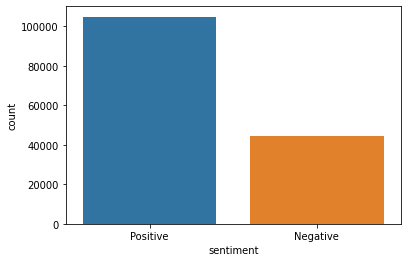

In [0]:
sns.countplot('sentiment',data=data_re)

**Pie Chart**

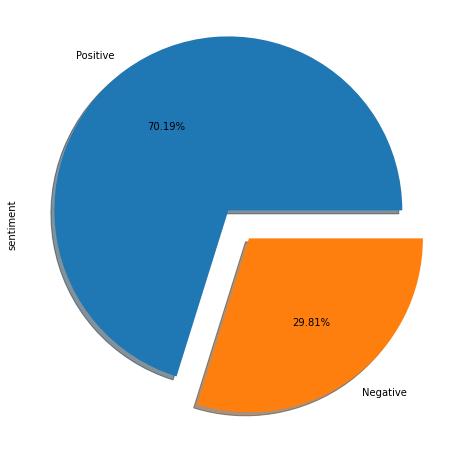

In [0]:
data_re['sentiment'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.2f%%',shadow=True,figsize=(10,8))

In [0]:
data_re.describe()
data_re.head(5)

,Rating,Reviews,sentiment
0,5,I feel so LUCKY to have found this used (phone...,Positive
1,4,"nice phone, nice up grade from my pantach revu...",Positive
2,5,Very pleased,Positive
3,4,It works good but it goes slow sometimes but i...,Positive
4,4,Great phone to replace my lost phone. The only...,Positive


Extend the StopWords set to include "Brand Name" & "Product Name" also so they can be excluded from Reviews during training.

In [0]:
stop_words = set(stopwords.words('english'))
stop_words_list=[]
for x in data["Product Name"]+" "+data["Brand Name"]:
    if isinstance(x,str):
      for j in x.split():
        if isinstance(j,str):
          stop_words_list.append(j)

stop_words_list_set=set(stop_words_list)
stop_words_set=stop_words|stop_words_list_set
print(len(stop_words_set))

6278



**Pre Processing Reviews**


In [0]:
# print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if (type(total_text) is not int) and (type(total_text) is not float):
        string = ""
        for words in total_text.split():
            word = ("".join(char for char in words if char.isalpha())) #remove the special chars like '"#$@!%^&*()_+-~?><
            word = word.lower()                                        # Convert all letters to lower-case
            if not word in stop_words_set:                             # stop-word removal
                string += word + " "
        data_re[column][index] = string
    else:
        pass
    return string

start_time = time.clock()
# we take each Review and we text-preprocess it.
with tqdm(total=data_re.shape[0]) as pbar:
  for index, row in data_re.iterrows():
      nlp_preprocessing(row['Reviews'], index, 'Reviews')
      pbar.update(1)
print("Total time taken to preprocess whole Reviews {0:.2f} seconds".format(time.clock() - start_time))


Total time taken to preprocess whole Reviews 147.15 seconds


**Add a new Columns "Review_length**

In [0]:
data_re["Review_len"]=data_re['Reviews'].apply(lambda x: len(x.split()))
print(data_re.groupby("sentiment")['Review_len'].agg('mean'))

sentiment
Negative    21.871129
Positive    19.890938
Name: Review_len, dtype: float64


**DistPlot** :- <br>&emsp;plot distribution of length of reviews. 

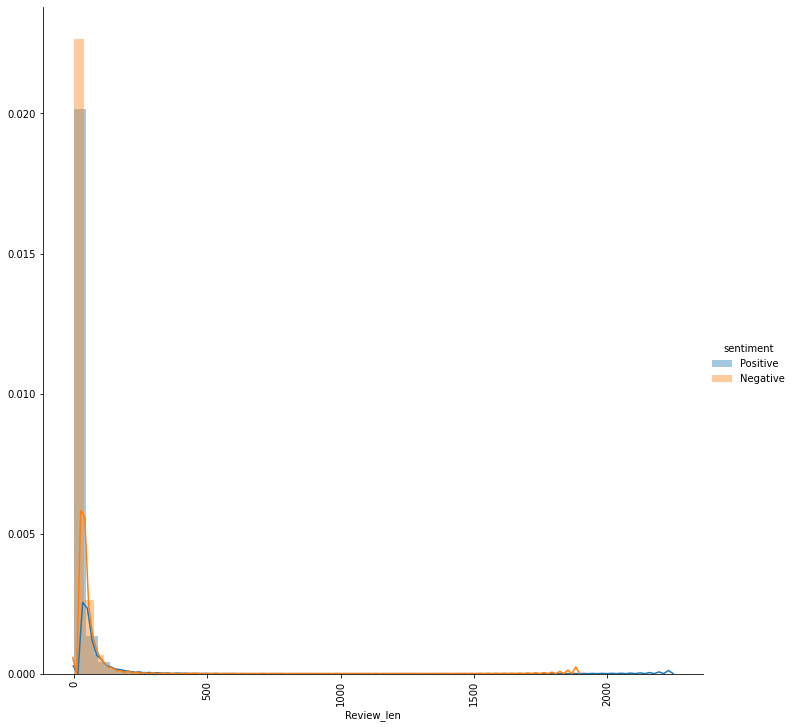

In [0]:
g=sns.FacetGrid(data_re, hue="sentiment", size=10) 
g.map(sns.distplot, "Review_len").add_legend();
plt.xticks(rotation='vertical')
plt.show();

Word-Frequency Histogram of 50 most common words in Positive Reviews

---



---



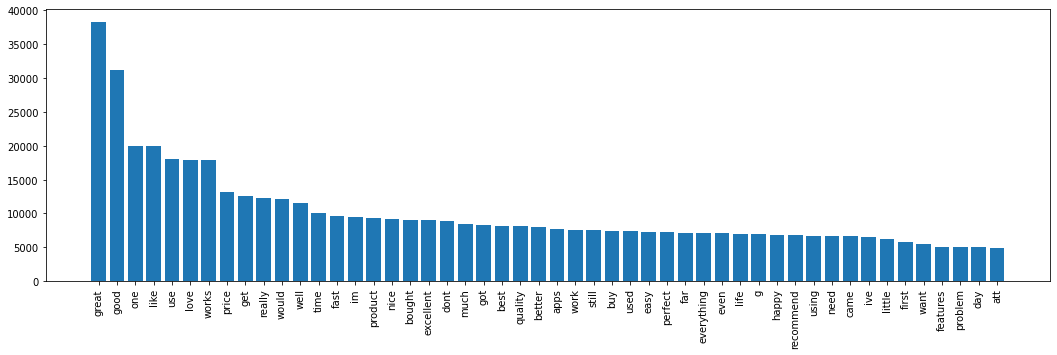

In [0]:
coun=Counter(" ".join(data_re[data_re["sentiment"]=="Positive"]["Reviews"]).split()).most_common(50)
words= [x[0] for x in coun]
values= [x[1] for x in coun]
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(18,5))
plt.bar(range(len(values)), values, align='center')
plt.xticks(range(len(words)), words, rotation='vertical')
plt.show()

Word-Frequency Histogram of 50 most common words in Negative Reviews

---



---




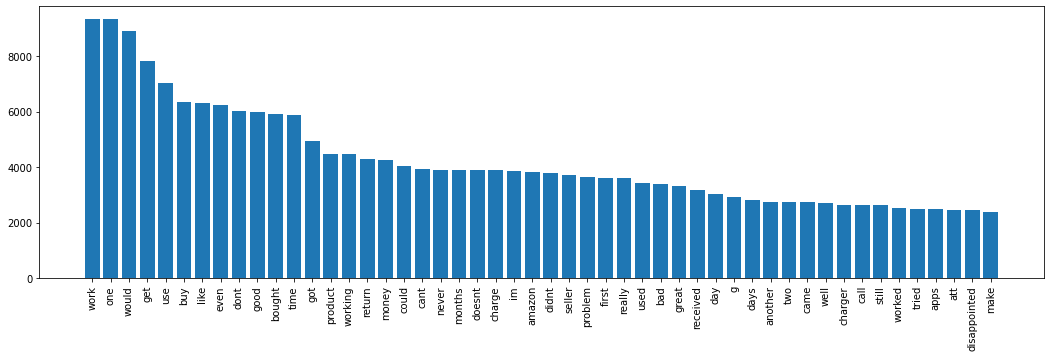

In [0]:
coun=Counter(" ".join(data_re[data_re["sentiment"]=="Negative"]["Reviews"]).split()).most_common(50)
words= [x[0] for x in coun]
values= [x[1] for x in coun]
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(18,5))
plt.bar(range(len(values)), values, align='center')
plt.xticks(range(len(words)), words, rotation='vertical')
plt.show()

In [0]:
data_re.shape

(149346, 4)

**Calculate Model Performance**<br>

---



---


We can use 3 parameters to evaluate model Performance


*   Accuracy

*   Classification Report

*   Confusion Report



In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
def model_efficiency(y_test, y_pred):
    print ("\nAccuracy on validation set: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))
    print("\nConfusion Matrix : \n", confusion_matrix(y_test, y_pred))
    print("\nClassification report : \n", classification_report(y_test, y_pred))


**Train Test Split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_re['Reviews'], data_re['sentiment'], \
                                                    test_size=0.3, random_state=0)

print('We have %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))

We have 104542 training examples and 44804 validation examples. 



#### Frequency based Embedding

---



Count Vector

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))
X_train_count=vectorizer.fit_transform(X_train)
X_test_count=vectorizer.transform(X_test)

1) A unique rank is given to each word in the data in accordance of their alphabetical order.
<br>&emsp;See below

In [0]:
import operator
sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))[:100]
vectorizer.vocabulary_["good"]

30257

*   For a data set of N observations. We create a N * M matrix,where M is the   count of all the unique words in the data. 
*   Matrix will have a value=frequency of word if the corresponding columns/word is present else 0. 
*   But a single observation do not have all the words /columns so most of the element of the matrix will remain empty(=**0**). 
*   Hence, it is represented by a <b>Sparse Matrix.</b>






In [0]:
print(type(X_train_count),X_train_count.shape)
print(X_train_count.shape[1])
print(len(vectorizer.vocabulary_.items()))

<class 'scipy.sparse.csr.csr_matrix'> (104542, 83969)
83969
83969


114772 is the number of training observations and 90598 is number of columns/words.<br>


Let us look how word are converted into number for each observation.<br>
For this let us see how observation no 4 is converted using frequency based embedding.

---



In [0]:
print("The fourth observation in data is as below :-\n",X_train.iloc[3])
for i in X_train.iloc[3].split():
  print("rank of word \"{}\" in vocab is {}".format(i,vectorizer.vocabulary_[i]))

The fourth observation in data is as below :-
 works beautifully 
rank of word "works" in vocab is 82384
rank of word "beautifully" in vocab is 6741


In [0]:
print("\nThe non zero columns in the training example no 3 are :-",X_train_count[3].nonzero()[1])


The non zero columns in the training example no 3 are :- [82384  6741]


In [0]:
print("\nHence in the Sparse Marix columns corresponding to only these values are non zero rest are 0 \n",X_train_count[3],)


Hence in the Sparse Marix columns corresponding to only these values are non zero rest are 0 
   (0, 82384)	1
  (0, 6741)	1


Accessing sparse matrix values:-

In [0]:
print(X_train_count[3,82384],X_train_count[3,6741])

1 1


1 is the frequency of the word in that observation.

In [0]:
print(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(33246)])

higherthese


**Using MultinomialNB**


In [0]:
mnb = MultinomialNB()
mnb.fit(X_train_count, y_train)
y_pred=mnb.predict(X_test_count)
model_efficiency(y_test,y_pred)


Accuracy on validation set: 90.11 %

Confusion Matrix : 
 [[10249  2886]
 [ 1547 30122]]

Classification report : 
               precision    recall  f1-score   support

    Negative       0.87      0.78      0.82     13135
    Positive       0.91      0.95      0.93     31669

    accuracy                           0.90     44804
   macro avg       0.89      0.87      0.88     44804
weighted avg       0.90      0.90      0.90     44804



In [0]:
print(mnb.class_count_)                                                 #Number of samples present for each class.
print(mnb.class_log_prior_)                                             #log(class sample /total samples).
print(mnb.coef_.shape)                                                  #feature log probability.
print(sum(mnb.coef_[0]))
print(mnb.feature_count_.shape)                                   #count of number of features/words for each class.

[31390. 73152.]
[-1.20309953 -0.35704944]
(1, 83969)
-1118110.2685701905
(2, 83969)


**LOGISTIC REGRESSION**

Logistic with regularization

In [0]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression(random_state=0)
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1]}
model_lr = GridSearchCV(clf, param_grid=grid_values)
model_lr.fit(X_train_count, y_train)
y_pred=model_lr.predict(X_test_count)
model_efficiency(y_test,y_pred)


Accuracy on validation set: 90.98 %

Confusion Matrix : 
 [[10662  2473]
 [ 1570 30099]]

Classification report : 
               precision    recall  f1-score   support

    Negative       0.87      0.81      0.84     13135
    Positive       0.92      0.95      0.94     31669

    accuracy                           0.91     44804
   macro avg       0.90      0.88      0.89     44804
weighted avg       0.91      0.91      0.91     44804



*   Logistic with regularization is able to give more accuracy. <br> due to the following reasons:-<br>
>It can work well with little bit of correlation amongst the features.<br>
>It does not make Conditional Independency assumptions amongst the features.<br>
>The information/data on prior probabilities is not needed.

*   Recall score for Negative Reviews is closer to 1 means False Negative are less this time.
*   Precision score for Positive Reviews is closer to 1 means False Positive are less this time.





# TFIDF

---



---




>*   Tf stands for Term Frequency.
>
>*   Idf stands for Inverse Document Frequency.

Formulae:-
>*   Tf(word)= frequency of word in sentence/Total frequency of all words in that sentence
>*   IDF(word)=log(N/n)
    
    where,

>    N= Total Number of Sentences<br>
>    n=Number of sentence that contains the given "word"
> 
>    The idea of "idf"  here is to  penalise the common words.<br>
>    It scales down the count of  common words.




In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf=vectorizer.fit_transform(X_train)
X_test_tfidf=vectorizer.transform(X_test)

In [0]:
print(type(X_train_tfidf),X_train_tfidf.shape)
print(X_train_tfidf.shape[1])
print(len(vectorizer.vocabulary_.items()))
print("The fourth observation in data is as below :-\n",X_train.iloc[3])
for i in X_train.iloc[3].split():
  print("rank of word \"{}\" in vocab is {}".format(i,vectorizer.vocabulary_[i]))
print("\nThe non zero columns in the training example no 3 are :-",X_train_tfidf[3].nonzero()[1])


<class 'scipy.sparse.csr.csr_matrix'> (104542, 83969)
83969
83969
The fourth observation in data is as below :-
 works beautifully 
rank of word "works" in vocab is 82384
rank of word "beautifully" in vocab is 6741

The non zero columns in the training example no 3 are :- [ 6741 82384]


In [0]:
print("The fourth observation in data is as below :-\n\n",X_train.iloc[2])
print("\n")
for i in X_train.iloc[2].strip().split():
  print(vectorizer.vocabulary_[i],end=" ")
print("\n")
print("\nHence in the Sparse Marix columns corresponding to only these values are non zero rest are 0 \n\n",X_train_tfidf[2].nonzero()[1],)
# print("\nHence in the Sparse Marix columns corresponding to only these values are non zero rest are 0 \n",X_train_count[2].nonzero()[1],)

The fourth observation in data is as below :-

 arrived quickly packaged appropriately looked like instructions didnt work called verizon programmed working  mins 


4377 58494 51222 3867 41321 40525 36165 19413 82124 10169 79008 57077 82266 44205 


Hence in the Sparse Marix columns corresponding to only these values are non zero rest are 0 

 [44205 82266 57077 79008 10169 82124 19413 36165 41321  3867 51222 58494
  4377 40525]


**MultiNomialNB**

In [0]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred=mnb.predict(X_test_tfidf)
model_efficiency(y_test,y_pred)


Accuracy on validation set: 85.62 %

Confusion Matrix : 
 [[ 7055  6080]
 [  365 31304]]

Classification report : 
               precision    recall  f1-score   support

    Negative       0.95      0.54      0.69     13135
    Positive       0.84      0.99      0.91     31669

    accuracy                           0.86     44804
   macro avg       0.89      0.76      0.80     44804
weighted avg       0.87      0.86      0.84     44804



Here, Accuracy goes down as compare to Count Vectorizer. <br>
Clearly, Empirical Probability is reduced when idf penalty is used.

In [0]:
print(mnb.class_count_)#Number of samples present for each class.
print(mnb.class_log_prior_)#log(class sample /total samples)
print(mnb.coef_.shape)#feature log probability
print(sum(mnb.coef_[0]))
print(mnb.feature_count_.shape)#count of number of features/words for each class

[31390. 73152.]
[-1.20309953 -0.35704944]
(1, 83969)
-1031471.3161498529
(2, 83969)


**Regularized Logistic Regression**

In [0]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression(random_state=0)
grid_values = {'penalty': ['l1','l2'], 'C': [0.01,0.1,1]}
clf = GridSearchCV(clf, param_grid=grid_values)
clf.fit(X_train_tfidf, y_train)
print("clf.best_params_",clf.best_params_)
y_pred=clf.predict(X_test_tfidf)
model_efficiency(y_test,y_pred)

clf.best_params_ {'C': 1, 'penalty': 'l2'}

Accuracy on validation set: 91.64 %

Confusion Matrix : 
 [[10849  2286]
 [ 1460 30209]]

Classification report : 
               precision    recall  f1-score   support

    Negative       0.88      0.83      0.85     13135
    Positive       0.93      0.95      0.94     31669

    accuracy                           0.92     44804
   macro avg       0.91      0.89      0.90     44804
weighted avg       0.92      0.92      0.92     44804



Clearly, penalty is affecting the cost function also and helps in optimizations by gradient descent.

**As Expected TF-IDF is able to perform better than simple CountVectorizer**

# IDF calculation

In [0]:
import math
def n_containing(word):
    return sum(1 for blob in data_re['Reviews'] if word in blob.split())

def idf(word):
    return math.log((data.shape[0])/(n_containing(word)+1),10)

BOW weighted with IDF

We will replace the value of Count Vectorizer for each word by their IDF values.

In [0]:
idf_review_vectorizer = CountVectorizer()
idf_review_features = idf_review_vectorizer.fit_transform(data_re['Reviews'])
idf_review_features  = idf_review_features.astype(np.float)
for i in tqdm(idf_review_vectorizer.vocabulary_.keys()):           #iterate over each word in the vocabulary
    idf_val = idf(i)                                               #calculate idf value for each word  
    for j in idf_review_features[:, idf_review_vectorizer.vocabulary_[i]].nonzero()[0]:#iterate over all rows where word is present with a non zero value
        idf_review_features[j,idf_review_vectorizer.vocabulary_[i]] = idf_val           #assign that cell the idf value

The CountVectorizer values are replaced by their idf values.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(idf_review_features, data_re['sentiment'], \
                                                    test_size=0.1, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
model_efficiency(y_test,y_pred)

# Word To Vec

>*   Simple Word2Vec uses the pretrained word vectors   produced in 300 dimensions.
>*   Weighted Word2Vec scales(multiplies) the values of word vectors in each dimesnion by their IDF value.



In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
vocab = model.wv.vocab.keys()

def build_avg_vec(sentence, num_features, doc_id, m_name):
    featureVec = np.zeros((num_features,), dtype="float32")    #initialize numpy array of dimensions = 300 
    nwords = 0
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_review_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_review_features[doc_id, idf_review_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])  #add value of each word in each of 300 dimensions taken from the model .
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)            #normalise the values
    return featureVec                                         #return a 300 dimension vector for each sentence.

**Average Word2Vec Reviews**

In [0]:
doc_id = 0
avg_w2v_reviews = []

for i in data_re['Reviews']:
    avg_w2v_reviews.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

avg_w2v_reviews = np.array(avg_w2v_reviews) 

**Logistic Regression**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(avg_w2v_reviews, data_re['sentiment'], \
                                                    test_size=0.33, random_state=0)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
model_efficiency(y_test,y_pred)


Accuracy on validation set: 88.57 %

Classification report : 
               precision    recall  f1-score   support

    Negative       0.83      0.76      0.80     14423
    Positive       0.91      0.94      0.92     34862

    accuracy                           0.89     49285
   macro avg       0.87      0.85      0.86     49285
weighted avg       0.88      0.89      0.88     49285


Confusion Matrix : 
 [[11024  3399]
 [ 2235 32627]]


**Weighted Word2Vec Reviews**

In [0]:
doc_id = 0
wtd_w2v_reviews = []

for i in data_re['Reviews']:
    wtd_w2v_reviews.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1

wtd_w2v_reviews = np.array(wtd_w2v_reviews)

**Logistic Regression**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(wtd_w2v_reviews, data_re['sentiment'], \
                                                    test_size=0.33, random_state=0)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
model_efficiency(y_test,y_pred)

# LSTM


>*   It is a type of Recurrent Neural Network.
>
>*   It can process entire sequences of data.
>
>*   It can learn the context between the words of a sentence.






Preparing The Input


>Parameters

In [0]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
num_of_epochs=5

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils

di={"Positive":1,"Negative":0}
data_res=data_re.replace({"sentiment": di})

X_train, X_test, y_train, y_test = train_test_split(data_res["Reviews"], data_res['sentiment'], \
                                                    test_size=0.20, random_state=0)

tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

X_train_seq, X_valid_seq, y_train_seq, y_valid_seq = train_test_split(X_train_seq, y_train_seq, \
                                                    test_size=0.33, random_state=0)


print('X_train shape:', X_train_seq.shape) 
print('X_test shape:', X_test_seq.shape) 
print('X_valid shape:', X_valid_seq.shape) 
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape)
print('y_valid shape:', y_valid_seq.shape)

X_train shape: (80048, 100)
X_test shape: (29870, 100)
X_valid shape: (39428, 100)
y_train shape: (80048, 2)
y_test shape: (29870, 2)
y_valid shape: (39428, 2)


In [0]:
from numpy import random

def train_generator(features, labels, batch_size):
 batch_features = np.zeros((batch_size,maxlen))
 batch_labels = np.zeros((batch_size,nb_classes))
 while True:
     for i in range(batch_size):
        index= random.choice(len(features),1)
        batch_features[i]=features[index]
        batch_labels[i]=labels[index]
     yield batch_features, batch_labels

def validation_generator(features, labels, batch_size):
 batch_features = np.zeros((batch_size,maxlen))
 batch_labels = np.zeros((batch_size,nb_classes))
 while True:
     for i in range(batch_size):
        index= random.choice(len(features),1)
        batch_features[i]=features[index]
        batch_labels[i]=labels[index]
     yield batch_features, batch_labels

a=train_generator(X_train_seq, y_train_seq, batch_size)

In [0]:
# next(a)

**EarlyStopping**

In [0]:
from keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=2,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)



*   tokenizer is used to convert the word to index.
*   padding is used to make all sequences of same length by prepending with 0.



In [0]:
lstm_model = Sequential()
lstm_model.add(Embedding(top_words, 128, dropout=0.2))
lstm_model.add(LSTM(128,dropout_W=0.5,dropout_U=0.2)) 
lstm_model.add(Dense(nb_classes))
lstm_model.add(Activation('softmax'))
lstm_model.summary()

lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm_model.fit_generator(train_generator(X_train_seq, y_train_seq, batch_size), 
                     samples_per_epoch=X_train_seq.shape[0]//batch_size, nb_epoch=num_of_epochs,
                     validation_data=validation_generator(X_valid_seq, y_valid_seq, batch_size),
                     validation_steps=X_valid_seq.shape[0]//batch_size ,callbacks=[earlystopping])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_8 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2501/2501 [==============================] - 492s 197ms/step - loss: 0.2527 - accuracy: 0.8996 - val_loss: 0.3105 - val_accuracy: 0.9064
Epoch 2/5
2501/2501 [==============================] - 487s 195ms/step - loss: 0.1932 - accurac

In [0]:
pred = lstm_model.predict(X_test_seq)
y_pred=[np.argmax(x) for x in pred]
model_efficiency(y_test,y_pred)


Accuracy on validation set: 91.20 %

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      8744
           1       0.93      0.95      0.94     21126

    accuracy                           0.91     29870
   macro avg       0.90      0.89      0.89     29870
weighted avg       0.91      0.91      0.91     29870


Confusion Matrix : 
 [[ 7219  1525]
 [ 1104 20022]]


**Observations**:-
>**Accuracy**
*   The accuracy is quite good but as the classes are imbalanced, We should look at confusion matrix and classification report also.

**Classification Report**
>*   Precision close to 1 indicates False Positives are close to 0.<br>
>*   Recall close to 1 indicates False Negatives are close to 0.<br>

**Confusion Matrix**
>*   Out of 8744 Negative Reviews , our model is able to predict 7219 of them correctly.
>*   Out of 21126 Positive Reviews , our model is able to predict 20022 of them correctly.



In [0]:
print("Shape of output matrix in the embedding layer : ", \
      lstm_model.layers[0].output.shape) 

print("Shape of output matrix in the hidden layer : ", \
      lstm_model.layers[1].output.shape) 

print("Shape of output matrix in the output layer : ", \
      lstm_model.layers[2].output.shape) 

Shape of output matrix in the embedding layer :  (None, None, 128)
Shape of output matrix in the hidden layer :  (None, 128)
Shape of output matrix in the output layer :  (None, 2)


**EMBEDDING LAYER**

>*   Each of the words taken are represented in 128 dimensions by embedding layer
>*   Embedding layers in Keras are tuned to minimize the loss function by using the optimization method.
>*   It cannot capture complete word semantics.
>*   It is more like a lookup table for embedding of words.



**LSTM Weights**

>*   Each of the sequence is passed through all 128 LSTM units.
>*   For each units, 4 types of weights are learned at Forget gate ,Input Gate,Cell Update and Output Gate and 4 biases for each unit.

**Output Weights**

>*   The LSTM produces a number from each unit learned from the sequences. 
>*   The 128 length output is squashed into 2 output classes learning 128 * 2 weights and 2 biases.





**Loss Function** -Cross Entropy

>  *   Cross-entropy loss, measures the performance of a classification model whose output is a probability value between 0 and 1.
>  *   Cross-entropy loss increases as the predicted probability diverges from the actual label.
  *Formulae:-  
      For Each Class:<br>
      −∑y*log(p) for each observations,<br>
      y may be the target distribution and p is the approximation of the target distribution.



**Optimizers** - ADAM.

>*   Adaptive Moment Estimation
>*   The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
>*   learning rate=η/(sqrt(v(t) + ε)
  *   η=initial learning rate
  *   v(t)=estimates of the second moment of the gradients.

>*   θ(t+1) = θ(t) − l.r. * m(t)<br>
    m(t)=estimates of the first moment of the gradients.






# LSTM with Word2Vec

Here, We will use the words embedding obtained from pre-trained Word2Vec and use it as embedding for LSTM.

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True)
embedding_matrix = w2v_model.wv.syn0  
print("Shape of embedding matrix : ", embedding_matrix.shape) 
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (3000000, 300)



Preparig custom Embedding Layer from Word2vec
---
>Here we use fixed weights vectors for each word  taken from word2vec.<br>
>Also,we will not train the embedding layer 


In [0]:
EMBEDDING_DIM=300
top_words=len(tokenizer.word_index)+1
embedding_matrix = np.zeros((top_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.vocab:
        embedding_matrix[i] = w2v_model.word_vec(word)

In [0]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],trainable=False)

lstm_model_w2v = Sequential()
lstm_model_w2v.add(embedding_layer)
lstm_model_w2v.add(LSTM(128, dropout_W=0.5, dropout_U=0.5)) 
lstm_model_w2v.add(Dense(nb_classes))
lstm_model_w2v.add(Activation('softmax'))
lstm_model_w2v.summary()

lstm_model_w2v.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm_model_w2v.fit_generator(train_generator(X_train_seq, y_train_seq, batch_size), 
                     samples_per_epoch=X_train_seq.shape[0]//batch_size, nb_epoch=num_of_epochs,
                     validation_data=validation_generator(X_valid_seq, y_valid_seq, batch_size),
                     validation_steps=X_valid_seq.shape[0]//batch_size ,callbacks=[earlystopping])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 300)         27630600  
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_12 (Activation)   (None, 2)                 0         
Total params: 27,850,506
Trainable params: 219,906
Non-trainable params: 27,630,600
_________________________________________________________________
Epoch 1/5
2501/2501 [==============================] - 418s 167ms/step - loss: 0.3466 - accuracy: 0.8492 - val_loss: 0.2122 - val_accuracy: 0.8848
Epoch 2/5
2501/2501 [==============================] - 418s 167ms/step - loss: 0.2839 

In [0]:
pred = lstm_model_w2v.predict(X_test_seq)
y_pred=[np.argmax(x) for x in pred]
model_efficiency(y_test,y_pred)


Accuracy on validation set: 91.35 %

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      8744
           1       0.93      0.95      0.94     21126

    accuracy                           0.91     29870
   macro avg       0.90      0.89      0.89     29870
weighted avg       0.91      0.91      0.91     29870


Confusion Matrix : 
 [[ 7161  1583]
 [ 1001 20125]]


with Word2Vec as Embedding Layer and trainable=True

In [0]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],trainable=True)

model3 = Sequential()
model3.add(embedding_layer)
model3.add(LSTM(128, dropout_W=0.5, dropout_U=0.5)) 
model3.add(Dense(nb_classes))
model3.add(Activation('softmax'))
model3.summary()

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.fit_generator(train_generator(X_train_seq, y_train_seq, batch_size), 
                     samples_per_epoch=X_train_seq.shape[0]//batch_size, nb_epoch=num_of_epochs,
                     validation_data=validation_generator(X_valid_seq, y_valid_seq, batch_size),
                     validation_steps=X_valid_seq.shape[0]//batch_size ,callbacks=[earlystopping])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 300)         27630600  
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_13 (Activation)   (None, 2)                 0         
Total params: 27,850,506
Trainable params: 27,850,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2501/2501 [==============================] - 490s 196ms/step - loss: 0.2506 - accuracy: 0.8997 - val_loss: 0.2163 - val_accuracy: 0.9157
Epoch 2/5
2501/2501 [==============================] - 493s 197ms/step - loss: 0.1911 - accu

In [0]:
pred = model3.predict(X_test_seq)
y_pred=[np.argmax(x) for x in pred]
model_efficiency(y_test,y_pred)


Accuracy on validation set: 91.64 %

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      8744
           1       0.92      0.96      0.94     21126

    accuracy                           0.92     29870
   macro avg       0.91      0.89      0.90     29870
weighted avg       0.92      0.92      0.92     29870


Confusion Matrix : 
 [[ 7090  1654]
 [  844 20282]]


In [0]:
print("Shape of output matrix in the embedding layer : ", \
      model3.layers[0].output.shape) 

print("Shape of output matrix in the hidden layer : ", \
      model3.layers[1].output.shape) 

print("Shape of output matrix in the output layer : ", \
      model3.layers[2].output.shape) 

Shape of output matrix in the embedding layer :  (None, None, 300)
Shape of output matrix in the hidden layer :  (None, 128)
Shape of output matrix in the output layer :  (None, 2)


**Testing on Real World Reivews**<br><br>
>I tested the model on few real world reviews taken from this url:-<br>
>
>https://www.commonsensemedia.org/app-reviews/tiktok/user-reviews

In [0]:
def nlp_preprocessing(total_text):
    if (type(total_text) is not int) and (type(total_text) is not float):
        string = ""
        for words in total_text.split():
            word = ("".join(char for char in words if char.isalpha())) #remove the special chars like '"#$@!%^&*()_+-~?><
            word = word.lower()         # Conver all letters to lower-case
            if not word in stop_words_set:            # stop-word removal
                string += word + " "
    else:
        pass
    return string
reviews=["This is a great app for kids 10 and up. There is some lots of swearing and lots of singing and dancing. This is a really fun. My nine year old and 12 year old really enjoy it. There is an option to make a private account which is great. My only concern is the swearing. Most of it is s**t. But I would say this is a really positive app as long as you have a private account so in order for someone to view your posts you have to accept them. I think this app is alot like Instagram just ALOT more positive. There is alot of body positively unlike some other apps out there. Its a really good app and my daughters dont get alot of follow requests other then from their friends. I would definitely recommend this app."
,"I’m know I’m wasting my time to write a review of crazy freaky app and the app itself time wasting stuff . Short and simple this app is totally waste and too much violence"
,"No signup needed and on the second video, the cursing began, followed right after by sexually suggestive content.",
"Lots of fun for teens and grown ups! Yes there is some mature content but with privacy settings and monitoring by parents it can easily avoided. Me and my thirteen year old daughter love it!",
"It's good in concept, but the world is full of bad people who abuse others. TikTok's very nature, and it's ability to allow people to freely message underage users, who themselves can be coerced or tricked into revealing personal information, make it too dangerous for minors.",
"A lot of these negative reviews are false. As usual on the Common Sense Media, there is always parents hating on social media apps. If you make your account private, view your child's account, and make messages from friends only or no one, it is safe and suitable for kids.",
"I’m know I’m wasting my time to write a review of crazy freaky app and the app itself time wasting stuff . Short and simple this app is totally waste and too much violence",
"If you're child wants to get Tik Tok, make sure that their account is private and that they are only friend with people they know in real life."]
for i in reviews:
  cus_train_seq=nlp_preprocessing(i)
  cus_train_seq = tokenizer.texts_to_sequences([cus_train_seq])
  cus_train_seq = sequence.pad_sequences(cus_train_seq, maxlen=maxlen)
  prediction=np.argmax(model3.predict(cus_train_seq))
  if prediction==1:
    print(i,"\nPositive")
  elif prediction==0:
    print(i,"\nNegative")
  print("="*500)

This is a great app for kids 10 and up. There is some lots of swearing and lots of singing and dancing. This is a really fun. My nine year old and 12 year old really enjoy it. There is an option to make a private account which is great. My only concern is the swearing. Most of it is s**t. But I would say this is a really positive app as long as you have a private account so in order for someone to view your posts you have to accept them. I think this app is alot like Instagram just ALOT more positive. There is alot of body positively unlike some other apps out there. Its a really good app and my daughters dont get alot of follow requests other then from their friends. I would definitely recommend this app. 
Positive
I’m know I’m wasting my time to write a review of crazy freaky app and the app itself time wasting stuff . Short and simple this app is totally waste and too much violence 
Negative
No signup needed and on the second video, the cursing began, followed right after by sexuall

The results looks quite satisfying!

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```END!```